In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('./Delight/desc-dc2')
from processSEDs import *

from delight.io import *
from delight.utils import *

%matplotlib inline

In [2]:
fileName='parameters_DESC-DC2.cfg'
conf_file = os.path.realpath(os.path.join('./Delight/desc-dc2/tmp', fileName))
print(conf_file)
params = parseParamFile(conf_file, verbose=False, catFilesNeeded=False)
test_fileout_delight = params['target_catFile']
train_fileout_delight = params['training_catFile']
delight_testFileoutAbs=os.path.realpath(os.path.normpath(os.path.join("./", 'Delight', 'desc-dc2', test_fileout_delight)))
print('Delight test file:\n\t{}'.format(delight_testFileoutAbs))
delight_trainFileoutAbs=os.path.realpath(os.path.normpath(os.path.join("./", 'Delight', 'desc-dc2', train_fileout_delight)))

/pbs/throng/lsst/users/jocheval/Intern2022_PhotoZ/Delight/desc-dc2/tmp/parameters_DESC-DC2.cfg
Delight test file:
	/pbs/throng/lsst/users/jocheval/Intern2022_PhotoZ/Delight/desc-dc2/tmp/delight_data/test_gal_fluxredshifts.txt


In [3]:
processSEDs(conf_file, bias=True, k=1.0, xmin=1.0)

2022-04-28 16:34:28,783 ipykernel_launcher.py, processSEDs[1248] INFO --- Process SED ---


In [4]:
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms = readBandCoefficients(params)
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
bandNames = params['bandNames']
numBands, numCoefs = bandCoefAmplitudes.shape
sedNamesDelight = ['El_B2004a', 'Sbc_B2004a', 'Scd_B2004a', 'Im_B2004a', 'SB3_B2004a', 'SB2_B2004a', 'ssp_25Myr_z008', 'ssp_5Myr_z008']
fluxredshifts = np.loadtxt(delight_testFileoutAbs)
fluxredshifts_train = np.loadtxt(delight_trainFileoutAbs)
delightUntFac=2.22e10

(7552, 14)


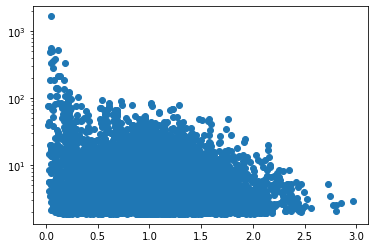

In [5]:
print(fluxredshifts.shape)
fig, ax = plt.subplots(1,1)
ax.scatter(fluxredshifts[:,-2], fluxredshifts[:,0])
ax.set_yscale('log')

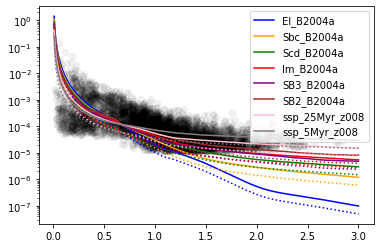

In [7]:
numFilt = 3
fig, ax = plt.subplots(1,1)
for sed, color in zip(np.arange(len(sedNamesDelight)),\
                      ['b', 'orange', 'g', 'r', 'purple', 'brown', 'pink', 'grey']):
    path = os.path.realpath(os.path.join("./", "Delight", "desc-dc2", "tmp", "data", "CWW_SEDs"))
    nameBias = sedNamesDelight[sed] + "_fluxredshiftmod-bias.txt"
    sedDataBias = np.loadtxt(os.path.join(path, nameBias))
    nameReg = sedNamesDelight[sed] + "_fluxredshiftmod.txt"
    sedDataReg = np.loadtxt(os.path.join(path, nameReg))
    ax.plot(redshiftGrid, sedDataBias[:, numFilt], c=color, label=sedNamesDelight[sed])
    ax.plot(redshiftGrid, sedDataReg[:, numFilt], c=color, ls=':')
ax.scatter(fluxredshifts[:, -2], fluxredshifts[:,numFilt*2]/np.sqrt(delightUntFac), alpha=0.05, c='k')
ax.set_yscale('log')
ax.legend()